# Lawlingo
Importing stuff

In [2]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import os
import urllib.request
from urllib import parse
import urllib.parse
import regex as re
import pandas as pd
from joblib import Memory
from datetime import datetime
import textract
from collections import Counter
import matplotlib.pyplot as plt
import csv
import itertools
memory = Memory('./cache', verbose=0)

In [24]:
@memory.cache
def text_from_url(url):
    urllib.request.urlretrieve(url, "./cache/temp.pdf")
    return textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')

@memory.cache
def get_domstol_se(section_url):
    BASE_URL = "https://www.domstol.se/"
    URL = BASE_URL + section_url
    BANNER_CLASS_NAME = "banner__button"
    MORE_CLASS_NAME = "search-result-item__show-more-btn"
    
    urls = []
    driver = webdriver.Chrome('./chromedriver')
    wait = WebDriverWait(driver, 10)
    driver.get(URL)
    sleep(1.0)
    
    banner_button = driver.find_element_by_class_name(BANNER_CLASS_NAME)
    more_button = driver.find_element_by_class_name(MORE_CLASS_NAME)
    
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, BANNER_CLASS_NAME)))
    banner_button.click()
        
    while True:
        more_button.click()
        try:
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, MORE_CLASS_NAME)))
        except:
            break
        
    results = driver.find_elements_by_class_name("u-pr-huge--large")
    urls =  [item.get_attribute("href") for item in results]
    driver.close()
    return urls


@memory.cache
def data_from_pdf_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")

    pdf_element = soup.find("a", href=re.compile(r".+\.pdf"))
    date_element = soup.find("span", class_ = "publisher__byline")
   
    date = datetime.fromisoformat(date_element.text[:-1])
    if pdf_element is not None:
        pdf_url = BASE_URL + pdf_element["href"]
        file_name = re.findall(r"(.+\/)*(.+\..+)$", pdf_url)[0][1]
        text_fr
        return {"date": date, "url": url, "text": text}
        
    else:
        return None
    
def words(text):
    """
    Returns a list of words from a text.
    """
    text = text.lower()
    text = re.sub('\n', " ", text)
    text = re.sub('[/./?,!/:/(/)_]', "", text)
    text = re.sub('[0-9]', "", text)
    words = text.split()
    return words



In [27]:
# This does not work for the urls that contains non-ascii characters. 
@memory.cache
def get_migrations():
    data = []
    
    # From csv
    with open("./migrations_dommar.csv", newline='',  encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = row['Date']
            url = row['Url']
            if url[-3:] != "pdf":
                data.append(data_from_pdf_page(url))
                continue
            try:
                urllib.request.urlretrieve(url, "./cache/temp.pdf")
            except:
                print("Could not fetch ", date, url)
                continue
            text = textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')
            data.append({'date': datetime.fromisoformat(date), 'url': url, 'text': text})
            
    # From folder
    folder = './MigrationsoÌverdomstolen avgoÌranden/'
    for file_name in os.listdir(folder):
        print(file_name)
        date = file_name[:10]
        url = folder + file_name
        text = textract.process(url, encoding='utf-16').decode('utf-16')
        data.append({'date': datetime.fromisoformat(date), 'url': url, 'text': text})
    
    return data

In [39]:
@memory.cache
def get_arbets():
    data = []
    URL = "http://www.arbetsdomstolen.se/pages/page.asp?lngID=4&lngLangID=1&Year={}"
    BASE = "http://www.arbetsdomstolen.se/pages/page.asp"
    for year in range(2003, 2020):
        page = requests.get(URL.format(year))
        soup = BeautifulSoup(page.text, 'html.parser')
        content = soup.find(id="content")

        for element in content.find_all("li"):
            result_url = element.find("a")['href']
            pdf_url = _arbets_pdf(BASE + result_url)
            title = element.find("strong").contents[0]
            date = re.findall("\d{4}-\d{2}-\d{2}", title)[0]
            if pdf_url is not None:
                try:
                    text = text_from_url(pdf_url)
                except:
                    print("Failed", pdf_url)
                    continue
                data.append({"date": datetime.fromisoformat(date), "url": pdf_url, "text": text})
                print("Downloaded", pdf_url)

    return data

def _arbets_pdf(url):
    BASE = "http://www.arbetsdomstolen.se/"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    for link in soup.find_all("a"):
        if re.match(r".+\.pdf", str(link.get('href'))):
            return BASE + link['href'][2:]
    
    return None
        

## Downloading and sorting data from decisions.

In [4]:
# Adding decistions from Högsta Domstolen
df_hd = pd.DataFrame([data_from_pdf_page(url) for url in get_domstol_se("hogsta-domstolen/avgoranden/?f=DecisionType_list:decision") if data_from_pdf_page(url) is not None])
df_hd["type"] = "HD"

In [5]:
# Adding decistions from Högsta förvaltningsdomstolen
df_fd = pd.DataFrame([data_from_pdf_page(url) for url in get_domstol_se("hogsta-forvaltningsdomstolen/avgoranden/") if data_from_pdf_page(url) is not None])
df_fd["type"] = "FD"

In [9]:
# Adding descisions from Migrationsdomstolen
df_md = pd.DataFrame(get_migrations())
df_md["type"] = "MD"

In [202]:
# Adding descisions from Arbetsdomstolen
df_ad = pd.DataFrame(get_arbets())
df_ad["type"] = "AD"

In [42]:
df = pd.DataFrame().append([df_hd, df_fd, df_md, df_ad])

In [43]:
# Counting words
df['word_count'] = list(map(lambda x: Counter(words(x)), df['text']))
df['n_words'] = list(map(lambda x: len(words(x)), df['text']))

# Counting occurences of blacklisted words
with open('./svartlistadeord.txt') as f:
    illegal_words = tuple(f.read().splitlines())
    
with open('./svartlistadeordstammar.txt') as f:
    illegal_word_stems = tuple(f.read().splitlines())
    
def illegal_count(text):
    counter = Counter()
    for word in illegal_word_stems:
        key = r"\s(" + word + "\p{L}+)"
        matches = re.finditer(key, text)
        counter.update([m.group(1) for m in matches])
        
    for word in illegal_words:
        key = r"\s(" + word + ")"
        matches = re.finditer(key, text)
        counter.update([m.group(1) for m in matches])
        
    return counter
    
df['illegal_count'] = list(map(illegal_count, df['text']))
df['n_illegal_occurences'] = list(map(lambda x: sum(x.values()), df['illegal_count']))

# Calculating the ratio of blacklisted words
df['illegal_ratio'] = df['n_illegal_occurences']/df['n_words']

## Plotting data

In [206]:
df.set_index('date', inplace=True)

In [207]:
df = df.sort_index()

In [208]:
print("Mean illegal ratio HD:", df.loc[df['type'] == "HD"]['illegal_ratio'].mean())
print("Mean illegal ratio MD:", df.loc[df['type'] == "MD"]['illegal_ratio'].mean())
print("Mean illegal ratio FD:", df.loc[df['type'] == "FD"]['illegal_ratio'].mean())

Mean illegal ratio HD: 0.00537130210875959
Mean illegal ratio MD: 0.0035231176514371023
Mean illegal ratio FD: 0.004548303783287122


,level_0,index,url,text,type,word_count,n_words,illegal_count,n_illegal_occurences,illegal_ratio
date,,,,,,,,,,
2014-10-02,1983,1983,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2014/45355/,HFD 2014 ref 55\nEtt beslut att inte lämna ut information enligt 26 § personuppgiftslagen på gru...,FD,"{'hfd': 1, 'ref': 1, 'ett': 4, 'beslut': 10, 'att': 15, 'inte': 10, 'lämna': 4, 'ut': 6, 'inform...",485,{},0,0.0
2010-06-16,520,520,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2010/49908/,"1 (3)\n\nREGERINGSRÄTTENS\nDOM\nMål nr\n2671-09, 2673-09 och\n2674-09\n\nmeddelad i Stockholm de...",FD,"{'regeringsrättens': 3, 'dom': 5, 'mål': 6, 'nr': 5, '-': 15, 'och': 7, 'meddelad': 1, 'i': 9, '...",270,{},0,0.0
2013-11-18,1696,1696,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2013/46619/,1 (2)\n\nHÖGSTA\nFÖRVALTNINGSDOMSTOLENS\nDOM\nMål nr\n4061-13\n\nmeddelad i Stockholm den 18 nov...,FD,"{'högsta': 6, 'förvaltningsdomstolens': 2, 'dom': 2, 'mål': 2, 'nr': 2, '-': 5, 'meddelad': 1, '...",299,{},0,0.0
2013-11-21,1702,1702,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2013/46615/,1 (2)\n\nHÖGSTA\nFÖRVALTNINGSDOMSTOLENS\nDOM\nMål nr 730-13\nmeddelad i Stockholm den 21 novembe...,FD,"{'högsta': 5, 'förvaltningsdomstolens': 2, 'dom': 2, 'mål': 2, 'nr': 2, '-': 6, 'meddelad': 1, '...",200,{},0,0.0
2013-11-28,1710,1710,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2013/47065/,1 (4)\n\nHÖGSTA\nFÖRVALTNINGSDOMSTOLENS\nBESLUT\nMål nr\n2618-13\n\nmeddelat i Stockholm den 28 ...,FD,"{'högsta': 7, 'förvaltningsdomstolens': 2, 'beslut': 6, 'mål': 6, 'nr': 6, '-': 9, 'meddelat': 1...",580,{},0,0.0
...,...,...,...,...,...,...,...,...,...,...
2016-05-10,2447,2447,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2016/43480/,,FD,{},0,{},0,NaN
2016-06-16,2493,2493,https://www.domstol.se/hogsta-domstolen/avgoranden/2016/35890/,,HD,{},0,{},0,NaN
2016-11-07,2589,2589,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2016/43363/,,FD,{},0,{},0,NaN


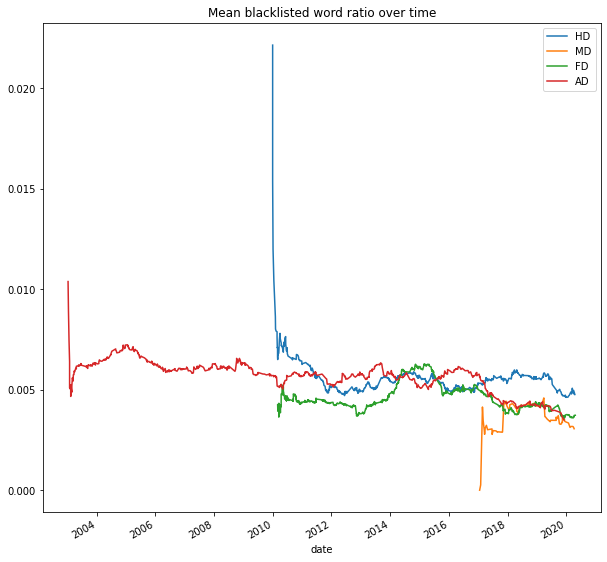

In [232]:
df.loc[df['type'] == 'HD']['illegal_ratio'].rolling('500d').mean().plot(label="HD", legend = True, title= 'Mean blacklisted word ratio over time', figsize=(10, 10))
df.loc[df['type'] == 'MD']['illegal_ratio'].rolling('500d').mean().plot(label="MD", legend = True)
df.loc[df['type'] == 'FD']['illegal_ratio'].rolling('500d').mean().plot(label="FD", legend = True)
df.loc[df['type'] == 'AD']['illegal_ratio'].rolling('500d').mean().plot(label="AD", legend = True)


## Most common blacklisted words

In [248]:
counter = Counter()
for count in df['illegal_count'].iloc:
    counter += count
counter.most_common(20)

[('företa', 8659),
 ('föreligger', 5392),
 ('förelegat', 2643),
 ('förelegat ', 2036),
 ('föreligga', 1741),
 ('förelåg', 1580),
 ('erfar', 1218),
 ('underlåtit', 1204),
 ('erfaren', 1178),
 ('föranlett', 1178),
 ('förfall', 950),
 ('erhållit', 912),
 ('erhålla', 751),
 ('underlåten', 719),
 ('föranleder', 670),
 ('jämkas', 640),
 ('nyttja', 616),
 ('erhöll', 601),
 ('förordnande', 559),
 ('föranleda', 549)]

## Decisions with zero blacklisted words

In [260]:
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', 10)

           type                                                                               url
date                                                                                             
2003-02-12   AD                               http://www.arbetsdomstolen.se//upload/pdf/15-03.pdf
2010-03-03   FD        https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2010/50015/
2010-03-15   FD        https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2010/50003/
2010-03-15   FD        https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2010/50007/
2010-03-17   FD        https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2010/50280/
...         ...                                                                               ...
2020-03-25   HD                    https://www.domstol.se/hogsta-domstolen/avgoranden/2020/57560/
2020-04-01   MD  https://www.domstol.se/migrationsoverdomstolen/vagledande-avgoranden/2020/60124/
2020-04-01   FD     

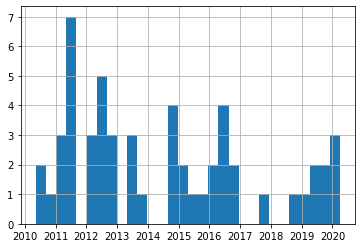

In [355]:
print(df.loc[df['n_illegal_occurences'] == 0][['type', 'url']].sort_values(['date']))
df2 = df.reset_index()
df2.loc[(df2['n_illegal_occurences'] == 0) & (df2['type'] == "HD")]['date'].hist(bins = 30)

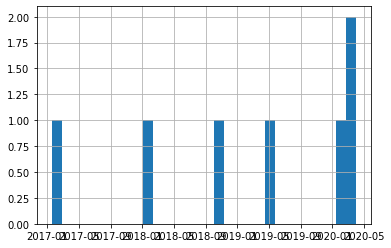

In [359]:
df2.loc[(df2['n_illegal_occurences'] == 0) & (df2['type'] == "MD")]['date'].hist(bins = 30)

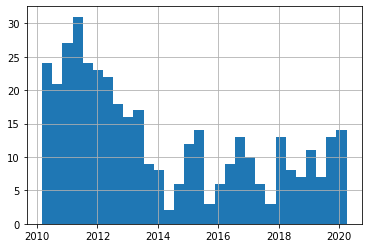

In [357]:
df2.loc[(df2['n_illegal_occurences'] == 0) & (df2['type'] == "FD")]['date'].hist(bins = 30)

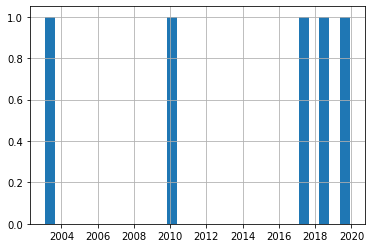

In [356]:
df2.loc[(df2['n_illegal_occurences'] == 0) & (df2['type'] == "AD")]['date'].hist(bins = 30)

In [320]:
# Max
df2 = df.reset_index()
df2.loc[df2.groupby(['type'])['illegal_ratio'].idxmax()][['url', 'type', 'illegal_ratio']]

,url,type,illegal_ratio
312,http://www.arbetsdomstolen.se//upload/pdf/2008/75-08.pdf,AD,0.032491
2500,https://www.domstol.se/hogsta-forvaltningsdomstolen/avgoranden/2016/43678/,FD,0.038952
2991,https://www.domstol.se/hogsta-domstolen/avgoranden/2018/35202/,HD,0.037219
2903,./MigrationsoÌverdomstolen avgoÌranden/2017-11-14.pdf,MD,0.030780
